# 라이브러리 불러오기

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import selenium
import konlpy

import warnings
warnings.filterwarnings("ignore")

## Step 1. 웹 크롤링

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time


# 크롤링할 사이트 주소를 정의합니다.
source_url = 'https://map.kakao.com/'

# 크롬 드라이버를 사용합니다 ( 윈도우는 두번째 줄 실행)
driver = webdriver.Chrome('C:/python/chromedriver_win32/chromedriver.exe')  # 크롬 드라이버로 크롬 켜기  

# 카카오 지도에 접속합니다
driver.get(source_url)

# 검색창에 검색어를 입력합니다
searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 눌러서 결과를 가져옵니다
searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용

https://place.map.kakao.com/95713992
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/741391811
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/13573220
https://place.map.kakao.com/2062959414
https://place.map.kakao.com/168079537
https://place.map.kakao.com/27238067
https://place.map.kakao.com/263830255
https://place.map.kakao.com/1052874675
https://place.map.kakao.com/1907052666
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/1111006760
https://place.map.kakao.com/1511737742


In [4]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome('C:/python/chromedriver_win32/chromedriver.exe')  # for Windows
for page_url in page_urls:
    
    # 상세보기 페이지에 접속합니다
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    # 별점을 가져옵니다.
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰를 가져옵니다.
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            # 별점을 가져옵니다.
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰를 가져옵니다.
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [5]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head(15)

(350, 3)


,score,review,y
0,3,,0
1,5,여기는 무조건 치즈 추가 필수 줄여서 치추필 기억하세요 치추필 뭐라고요 치추필,1
2,5,치즈닭갈비 너무맛있어요 ㅠㅠ 깔끔하고 좋아요,1
3,5,동네에 체인점 있었을 때 맛있어서 많이 갔었는데~~! 지금은 없어졌지만 강남 들른김...,1
4,5,양 많고 맛있네요~!,1
5,5,닭갈비 양도 많고 맛있어요!,1
6,5,여긴 치즈추가 필수에요 ㅜㅜ 매콤한 닭갈비에 싸악 싸먹으면…. 가성비도 넘 좋아용 ...,1
7,5,정말 맛있어요.. 가성비최고,1
8,1,난생 처음 보는 비상식적인 응대에 감탄하고 갑니다. 직원분이 하시는 말 못 들은 상...,0
9,1,사회적 상황이 악화되는 상황에서 좀 나은 서비스로 장사 하세요 서비스 너무 최 악 ...,0


In [6]:
df.to_csv("review_data.csv", index=False)

## Step 2. 전처리

In [7]:
df = pd.read_csv("review_data.csv")

In [8]:
import re
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거 -> 한글만 추출을 했음.
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')   # 한글과 띄어쓰기를 제외한 모든 글자.
    result = hangul.sub('', str(text)) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    return result

In [9]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df = pd.read_csv("review_data.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
1,3,0,양념이 너무 달다 그래도 배는 부름
2,1,0,알바생들이 교육이 잘안된건지 융통성이 없던건지ㅋㅋㅋㅋㅋ 볶음밥시켰는데 불이 계속 안...
3,1,0,먹다 수세미 조각 나와서 사장 나와라고 하고 싶었지만 용기가 없어서 그냥 나옴 가...
4,4,1,배불러요
5,1,0,옛전에는 이러지 않았는데 아쉽네요 닭갈비랑 볶음밥 양이 엄청 작아졌고 명동점은 닭갈...


## 2.2 형태소 단위로 추출

In [10]:
import tweepy
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

['양념/Noun', '이/Josa', '너무/Adverb', '달다/Verb', '그래도/Adverb', '배는/Verb', '부름/Verb']


## 2.3 분류 모델의 학습 데이터로 변환하기

### corpus index 생성하기

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
# tokenizer를 정의 : 스페이스바를 구분하여 나누어주는것.
# fit_transform : df의 tolist 말뭉치를 벡터를 카운트해주는 연산을 해줌.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [12]:
# 272개의 데이터가 2106개의 형태소가 들어있다.
X.shape

(285, 2215)

In [13]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'양념/Noun': 1361, '이/Josa': 1556, '너무/Adverb': 389, '달다/Verb': 466, '그래도/Adverb': 235, '배는/Verb': 91..


In [14]:
# 1288번벡터 937까지는 1 나머지는 0으로 되어있음.
print(df['ko_text'].values[0])
print(X[0])

양념이 너무 달다 그래도 배는 부름
  (0, 1361)	1
  (0, 1556)	1
  (0, 389)	1
  (0, 466)	1
  (0, 235)	1
  (0, 918)	1
  (0, 988)	1


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
# TF-IDF 텍스트 마이닝에서 이용하는가중치. 특정 문서내에서 얼마나 중요한지를 알수있는 통계적 수치.
# 1에 높을수록 많은 수치. 0에 가까울수록 적은 수치.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [55]:
# 다른 문서들에도 얼마나 나오는지 확인.
print(X.shape)
print(X[0])

(285, 2215)
  (0, 235)	0.42719491803649035
  (0, 389)	0.1140761893746495
  (0, 466)	0.49180501331475335
  (0, 918)	0.49180501331475335
  (0, 988)	0.49180501331475335
  (0, 1361)	0.27498915506297866
  (0, 1556)	0.057057657283929406


# Step 3. 분류 : 긍정 부정 리뷰 분류하기

## 분류 모델링

### 데이터셋 분리

In [56]:
# 테스트와 실험 데이터를 나눔.
# 7:3 으로 나눔
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(199, 2215)
(86, 2215)


## Step 4. <분석>

### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1] # auc를 계산하기 위한 계산식.

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.57
Precision : 0.576
Recall : 0.980
F1 : 0.726


In [58]:
# 극단적인 모델이 만들어짐.
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 0 36]
 [ 1 49]]


AUC : 0.856


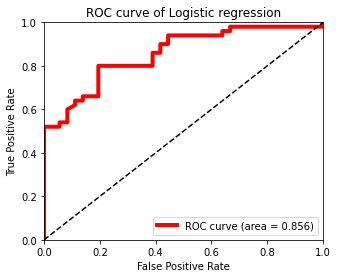

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4] # 그래프 사이즈
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

# Step 5. 활용 : 중요 키워드 분석

## 회귀모델의 피처 영향력 추출

<BarContainer object of 2215 artists>

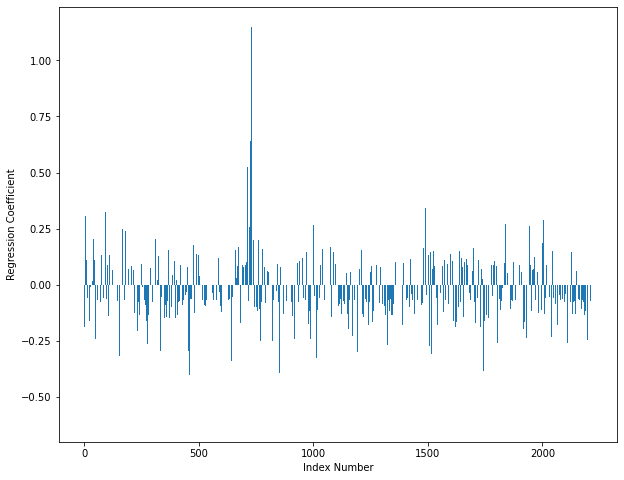

In [68]:
# 학습한 회귀 모델의 계수를 출력합니다.
# 각 x가 y값에 얼마나 영향을 주는지 나타내는것.
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel('Index Number')
plt.ylabel('Regression Coefficient')
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [69]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.1496255924694365, 730), (0.8861027696206428, 737), (0.6423640294191645, 726), (0.5764574120982886, 709), (0.5255386004269242, 713)]
[(-0.46769812775484737, 951), (-0.48299714468144056, 1390), (-0.5055842826366723, 159), (-0.5162004412911856, 496), (-0.6106145486986049, 1556)]


## 중요 피처의 형태소

In [70]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [71]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{1361: '양념/Noun', 1556: '이/Josa', 389: '너무/Adverb', 466: '달다/Verb', 235: '그래도/Adverb', 918: '배는/Verb..


In [72]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 1.1496255924694365
맛있음/Adjective 0.8861027696206428
맛있습니다/Adjective 0.6423640294191645
맛있게/Adjective 0.5764574120982886
맛있네요/Adjective 0.5255386004269242
넘/Verb 0.5203509830464659
존맛/Noun 0.5106030532848642
ㅎㅎ/KoreanParticle 0.4530030450780512
최고/Noun 0.4161091565839285
좋네요/Adjective 0.3981748188829487
완전/Noun 0.39655733525550163
깔끔하고/Adjective 0.38435704737816356
왔어요/Verb 0.3417026017228314
친절하시고/Adjective 0.32346324109477215
갑/Noun 0.32288921779994617
구워주시고/Verb 0.3190329642325413
된장찌개/Noun 0.3174378180451434
먹었어요/Verb 0.30753679209218093
배불러요/Adjective 0.30730667022952995
맛있댜/Noun 0.30730667022952995


In [73]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

요/Josa -0.3594089380103578
반찬/Noun -0.3636569653190999
별로/Noun -0.3689433483679204
점/Noun -0.38350706058150646
가격/Noun -0.38536574604761087
비추/Verb -0.38931703417722696
무질/Noun -0.392961513791947
겨/Noun -0.392961513791947
마세요/Verb -0.39879778953999495
닥/Noun -0.3991203609317251
가지/Noun -0.4023953500133597
는/Josa -0.4078999485389708
건지/Verb -0.4111537998308524
은/Josa -0.43746889849168935
좀/Noun -0.44250218448454154
보단/Josa -0.46769812775484737
없고/Adjective -0.48299714468144056
고기/Noun -0.5055842826366723
대비/Noun -0.5162004412911856
이/Josa -0.6106145486986049


### 품사별 긍정 형태소 10개, 부정 형태소 10개

In [27]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [28]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('존맛/Noun', 0.6091819130514096),
 ('최고/Noun', 0.5765485686158516),
 ('술/Noun', 0.3938880537966917),
 ('완전/Noun', 0.3638015298223194),
 ('가성/Noun', 0.3275444684467627),
 ('쫀득살/Noun', 0.3035468254754522),
 ('거기/Noun', 0.3030871301084868),
 ('사이드/Noun', 0.29721934129365923),
 ('맛있댜/Noun', 0.29187960561961473),
 ('맛맛/Noun', 0.29187960561961473)]

In [29]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('맛있어요/Adjective', 1.2039915978518736),
 ('맛있음/Adjective', 0.8152071812980459),
 ('맛있고/Adjective', 0.6756761437330765),
 ('맛있게/Adjective', 0.6251837191232374),
 ('맛있네요/Adjective', 0.35736195817705485),
 ('맛있습니다/Adjective', 0.34899228355435924),
 ('괜찮음/Adjective', 0.33188086997325317),
 ('좋네요/Adjective', 0.2755093068458876),
 ('괜찮았어요/Adjective', 0.2551019874229683),
 ('고소한/Adjective', 0.2486095714338775)]